<a href="https://colab.research.google.com/github/ipietri/w266_Final_Project/blob/master/notebooks/RtGender-Notebooks/Removed_Irrelevant_Mixed/RtGender_Sentiment_Greyscaling_Universal_Sentence_Encoder_Removing_Irrelevant_%26_Mixed_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

[link text](https://)# Universal Sentence Encoder


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=google%2Funiversal-sentence-encoder%2F4%20OR%20google%2Funiversal-sentence-encoder-large%2F5"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.


## Setup

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [ ]:
%%capture
!pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [2]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
#@title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Similarity

In [5]:
train_df_aug = pd.read_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_rtgender_train_data_excluding_irrelevant_and_mixed.csv')
train_df_aug['list_text'] = train_df_aug['text'].apply(lambda x: x.split())

In [6]:
import math

# get each unique id and then cycle through
unique_id_list = train_df_aug['id'].unique().tolist()

# instantiate lists 
scores_list = []
cs_list = []
mean_list = []
og_sentence = []
augmented_sentence_list = []
id_list = []

# for every origin
for id in unique_id_list: 
  # subset the dataframe and separate original and augmented examples
  data = train_df_aug[train_df_aug['id'] == id]
  og = data[data['is_og'] == 1].iloc[0].text
  og_list = data[data['is_og'] == 1].iloc[0].list_text
  
  # return all augmented examples
  augmented = data[data['is_og'] == 0]

  # if there are no augmented examples add NA to list
  if len(augmented) == 0:
    id_list.append(id)
    scores_list.append(np.nan)
    cs_list.append(np.nan)
    mean_list.append(np.nan)
    og_sentence.append(og)
    augmented_sentence_list.append(np.nan)
    

  else: 
    # encode the original example; requires list format
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(og_list)), axis=1)
    for i in range(len(augmented)):
      example = augmented.iloc[i].text
      example_list_text = augmented.iloc[i].list_text
      # add the score for each augmented example to scores_list
      sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(example_list_text)), axis=1)
      
      #cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
      # encode1 = embed(tf.constant(og))
      # encode2 = embed(tf.constant(example))
      m = tf.keras.metrics.CosineSimilarity(axis = 1)
      m.update_state(sts_encode1, sts_encode2)
      
      cosine_similarities = m.result().numpy()
      clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
      scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi

      id_list.append(id)
      og_sentence.append(og)
      augmented_sentence_list.append(example)
      cs_list.append(cosine_similarities)
      scores_list.append(scores.numpy())
      
      mean_score = tf.reduce_mean(scores).numpy()
      mean_list.append(mean_score)


In [7]:
df_with_scores = pd.DataFrame({'id':id_list, 'og_sentence':og_sentence, 
              'augmented_sentence':augmented_sentence_list,
              'mean_arc_sine_score': mean_list})

df_with_scores

,id,og_sentence,augmented_sentence,mean_arc_sine_score
0,0,Thank you Congresswoman Bass. Keep up the grea...,Thank you Congresswoman Bass. Keep up the good...,0.941539
1,6,"Yay for useful, practical presi's!! :D","Yay for useful, possible presi's!! :D",0.852176
2,6,"Yay for useful, practical presi's!! :D","Yay for useful, realistic presi's!! :D",0.864039
3,6,"Yay for useful, practical presi's!! :D","Yay for useful, feasible presi's!! :D",0.871951
4,8,"Actually, they looked dopey, but they did pret...","Actually, they looked dopey, but they did hand...",0.913076
...,...,...,...,...
22500,21179,"""Committed to making sure we don't lose our he...",NaN,NaN
22501,21180,Both Isakson and Chambliss voted to TABLE Rand...,NaN,NaN
22502,21181,I think a magic beam of pure light would disin...,NaN,NaN
22503,21182,I'd rather have a root canal . . .,NaN,NaN


In [8]:
df_with_scores.to_csv('/content/drive/MyDrive/w266/universal_sentence_arc_df_rtgender_excluding_irrelevant_and_mixed.csv', index = False)

Visualize distribution

In [9]:
mean_arc_sine_score = df_with_scores['mean_arc_sine_score'].to_list()

[Text(0.5, 1.0, 'RtGender ex. Irrelevant and Mixed Examples - Mean Arc Sine Score')]

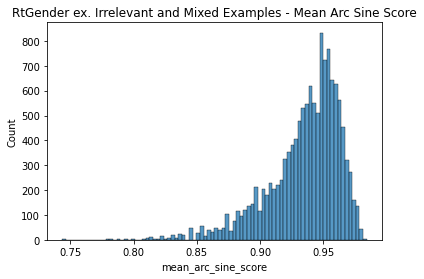

In [33]:
sns.histplot(df_with_scores['mean_arc_sine_score']).set(title='RtGender ex. Irrelevant and Mixed Examples - Mean Arc Sine Score')

In [11]:
print("P10: ", np.nanquantile(mean_arc_sine_score, 0.1))
print("P25: ", np.nanquantile(mean_arc_sine_score, 0.25))
print("P50: ", np.nanquantile(mean_arc_sine_score, 0.5))
print("P75: ", np.nanquantile(mean_arc_sine_score, 0.75))
print("P90: ", np.nanquantile(mean_arc_sine_score, 0.9))

p25_threshold = np.nanquantile(mean_arc_sine_score, 0.25)

P10:  0.8952153921127319
P25:  0.921305239200592
P50:  0.9414108991622925
P75:  0.9552498459815979
P90:  0.9646172642707824


Low match examples

In [12]:
# standard deviation ignoring NAs
np.nanstd(df_with_scores['mean_arc_sine_score'])

0.02877049307997615

In [13]:
df_with_scores[df_with_scores['mean_arc_sine_score'] < .95]

,id,og_sentence,augmented_sentence,mean_arc_sine_score
0,0,Thank you Congresswoman Bass. Keep up the grea...,Thank you Congresswoman Bass. Keep up the good...,0.941539
1,6,"Yay for useful, practical presi's!! :D","Yay for useful, possible presi's!! :D",0.852176
2,6,"Yay for useful, practical presi's!! :D","Yay for useful, realistic presi's!! :D",0.864039
3,6,"Yay for useful, practical presi's!! :D","Yay for useful, feasible presi's!! :D",0.871951
4,8,"Actually, they looked dopey, but they did pret...","Actually, they looked dopey, but they did hand...",0.913076
...,...,...,...,...
13176,21159,Bad decision to go on recess while we starve h...,mediocre decision to go on recess while we sta...,0.923667
13179,21165,"Im from Australia and as bad as we have it, br...","Im from Australia and as cheap as we have it, ...",0.940893
13180,21165,"Im from Australia and as bad as we have it, br...",Im from Australia and as mediocre as we have i...,0.947099
13181,21166,"many already had coverage, with doctors and pl...","some already had coverage, with doctors and pl...",0.947972


Strong Match Examples

In [14]:
strong_matches = df_with_scores[df_with_scores['mean_arc_sine_score'] > .994]

In [15]:
strong_matches[strong_matches['id'] == 521]

,id,og_sentence,augmented_sentence,mean_arc_sine_score


# Pre-process 

In [16]:
df_aug = pd.read_csv('/content/drive/MyDrive/w266/universal_sentence_arc_df_rtgender_excluding_irrelevant_and_mixed.csv')

Keep all original text plus all augmented examples that meet or exceed the 25th %tile

In [17]:
# set threshold at P25 
p25_threshold = np.nanquantile(df_aug.mean_arc_sine_score, 0.25)
print("threshold for similarity: ", p25_threshold)


threshold for similarity:  0.921305239200592


In [18]:
augmented_examples_to_remove = df_aug[df_aug['mean_arc_sine_score']< p25_threshold]['augmented_sentence'].to_list()
train_df_aug_rc = train_df_aug[~train_df_aug['text'].isin(augmented_examples_to_remove)]
train_df_aug_rc.to_csv('/content/drive/MyDrive/w266/grey_scaled_augmented_oversampled_rtgender_train_data_contextually_representative_ex_only_excluding_irrelevant_and_mixed.csv', index = False)



## Import Dev Data and Convert to HuggingFace friendly format

In [21]:
train_df = train_df_aug_rc
dev_df = pd.read_csv('/content/drive/MyDrive/w266/annotations_dev.csv')
print('dev_shape: ',dev_df.shape)

# there are NaNs in the dev dataset remove 
nan_values = dev_df[dev_df.isna().any(axis=1)] 
print(nan_values)

# return without missing values in response_text
dev_df.dropna(subset = ["response_text"], inplace=True)

# remove mixed sentiment and irrelevant examples
dev_df = dev_df[dev_df['relevance'] != 'Irrelevant']
dev_df = dev_df[dev_df['sentiment'] != 'Mixed']


print("Train shape", train_df.shape)
print("Dev shape", dev_df.shape)

dev_shape:  (2303, 9)
      Unnamed: 0         source op_gender  ...   relevance label labels_4
830         2576  facebook_wiki         M  ...  Irrelevant     1        1
1664        2722  facebook_wiki         W  ...  Irrelevant     1        1

[2 rows x 9 columns]
Train shape (23468, 6)
Dev shape (1821, 9)


In [22]:
# keep only a few columns and rename dev col names
dev_df = dev_df[['response_text', 'labels_4']]
dev_df.rename(columns = {'response_text':'text', 'labels_4': 'label'}, inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Huggingface friendly format

In [23]:
%%capture
!pip install datasets
import datasets 
from datasets import load_dataset, Dataset, DatasetDict

In [24]:
# change to dataset to work with Huggingface transformer & remove unused columns
columns_to_remove = ['id', '__index_level_0__']

train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

train_dataset = train_dataset.remove_columns(column_names= columns_to_remove)
dev_dataset = dev_dataset.remove_columns(column_names= '__index_level_0__')

# combine into a DataDictionary for huggingface use
rtg_dataset = DatasetDict({
    'train': train_dataset,
    'dev': dev_dataset 
})

rtg_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'is_og', 'new_col', 'list_text'],
        num_rows: 23468
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 1821
    })
})

# Tokenize 

In [25]:
%%capture
!pip install -q transformers
import transformers
import json
from tqdm import tqdm
#from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import logging
logging.basicConfig(level=logging.ERROR)

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [26]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
max_length = train_df['text'].astype(str).map(len).quantile(0.99).astype(int)
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length = int(max_length))

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

rtg_encoded = rtg_dataset.map(tokenize, batched=True, batch_size=None)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# Model

In [27]:
from transformers import AutoModelForSequenceClassification
num_labels = 3
epochs = 2
iterations = 3
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [28]:
rtg_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1_weighted = f1_score(labels, preds, average="weighted")
    f1_macro = f1_score(labels, preds, average = 'macro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1_weighted, "f1_macro": f1_macro} 

In [30]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(rtg_encoded["train"]) #// batch_size*5
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                 # metric_for_best_model="f1_macro",
                                 # weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  save_strategy="steps",
                                  disable_tqdm=False
                                  )

In [31]:
from sklearn.metrics import classification_report

accuracy_list = []
weighted_f1_score_list = []
macro_f1_score_list = []
negative_f1_score = []
neutral_f1_score = []
positive_f1_score = []


for i in range(iterations):
  try:
    del trainer
    del results
    del cr
  except: pass


  trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=rtg_encoded["train"],
                  eval_dataset=rtg_encoded["dev"])
  trainer.train()
  results = trainer.evaluate()

  # append macro metrics to lists
  accuracy_list.append(results.get('eval_accuracy'))
  weighted_f1_score_list.append(results.get("eval_f1"))
  macro_f1_score_list.append(results.get("eval_f1_macro"))

  trainer.predict(rtg_encoded["dev"])
  # append the class-level F1 scores
  outputs = trainer.predict(rtg_encoded["dev"])
  predictions = outputs.predictions.argmax(1)
  labels = rtg_encoded["dev"]['label']
  cr = classification_report(labels, predictions, digits=3, output_dict=True)
  negative_f1_score.append(cr.get('0').get("f1-score"))
  neutral_f1_score.append(cr.get('1').get("f1-score"))
  positive_f1_score.append(cr.get('2').get("f1-score"))


  print(f'---------------------------Iteration {i+1} Complete---------------------------\n')

Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.669600,0.635018,0.761669,0.763552,0.701420
1000,0.470400,0.758897,0.753432,0.758425,0.701155
1500,0.396100,0.751015,0.768259,0.765480,0.703556
2000,0.379200,0.746702,0.760571,0.766998,0.711363
2500,0.318600,0.968394,0.770456,0.768132,0.703650
3000,0.273400,1.027708,0.773751,0.774005,0.713625
3500,0.163500,1.101586,0.770456,0.771551,0.710230
4000,0.153300,1.160473,0.768259,0.759430,0.692683
4500,0.139600,1.250430,0.773751,0.770292,0.707374
5000,0.148100,1.183105,0.763866,0.762074,0.698404


---------------------------Iteration 1 Complete---------------------------



Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.265700,1.217081,0.731466,0.740572,0.687183
1000,0.466800,0.816305,0.761669,0.763987,0.703557
1500,0.375600,0.803047,0.765513,0.770481,0.714497
2000,0.352900,0.764311,0.772652,0.773041,0.715946
2500,0.288200,1.059796,0.772103,0.768305,0.704722
3000,0.257100,1.059037,0.768259,0.766261,0.701992
3500,0.147600,1.187680,0.769357,0.769368,0.708263
4000,0.124300,1.171588,0.765513,0.761086,0.698505
4500,0.119800,1.268968,0.774849,0.771066,0.711093
5000,0.133600,1.228996,0.772103,0.769364,0.709643


---------------------------Iteration 2 Complete---------------------------



Step,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
500,0.091800,1.522016,0.753981,0.756028,0.699150
1000,0.155600,1.344435,0.744646,0.744771,0.681549
1500,0.140100,1.640843,0.718287,0.729777,0.669761
2000,0.147000,1.297359,0.762219,0.759741,0.699438
2500,0.290000,1.208861,0.763317,0.758559,0.693652
3000,0.210100,1.313256,0.766612,0.760358,0.697751
3500,0.103700,1.406614,0.763317,0.755823,0.690957
4000,0.083100,1.365972,0.767710,0.763398,0.701616
4500,0.070100,1.474362,0.768808,0.765166,0.703140
5000,0.087500,1.445196,0.770456,0.766153,0.704864


---------------------------Iteration 3 Complete---------------------------



# Evaluate BERT

In [32]:
import statistics

print("%15s %s (%s)" % ("","Mean", "StDev"))

print("-"*29)
print("Macro Scores")
print("-"*29)

print(f"%15s %s (%s)" %("Accuracy",
    round(statistics.mean(accuracy_list),3),
    round(statistics.stdev(accuracy_list),3)))
print(f"%15s %5s (%s)" %("Macro F1",
    round(statistics.mean(macro_f1_score_list),3),
    round(statistics.stdev(macro_f1_score_list),3)))
print(f"%15s %5s (%s)" %("Weighted F1",
    round(statistics.mean(weighted_f1_score_list),3),
    round(statistics.stdev(weighted_f1_score_list),3)))

print("-"*29)
print("Class Scores")
print("-"*29)

print(f"%15s %s (%s)" %("Positive",
    round(statistics.mean(positive_f1_score),3),
    round(statistics.stdev(positive_f1_score),3)))
print(f"%15s %5s (%s)" %("Neutral",
    round(statistics.mean(neutral_f1_score),3),
    round(statistics.stdev(neutral_f1_score),3)))
print(f"%15s %5s (%s)" %("Negative",
    round(statistics.mean(negative_f1_score),3),
    round(statistics.stdev(negative_f1_score),3)))


                Mean (StDev)
-----------------------------
Macro Scores
-----------------------------
       Accuracy 0.766 (0.006)
       Macro F1 0.704 (0.011)
    Weighted F1 0.765 (0.007)
-----------------------------
Class Scores
-----------------------------
       Positive 0.868 (0.002)
        Neutral 0.575 (0.014)
       Negative 0.668 (0.021)
